# Set-up

In [1]:
# Set up environment
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
# Testing parameters: Only run on N samples if test=True
test = False
max_sample_test = 1000
# Maximum length of equation in # of tokens
max_length_token = 100
# Size of vocab in tokenizer, i.e. distinct number of tokens to learn
vocab_size = 600
# Batch size for DataLoader
batch_size = 256
# Report loss every N steps
report_step = 100
# Number of epochs to train. Each epoch is one cycle of training over full training set.
num_epoch = 3

In [ ]:
# Only run once per session

! if [ ! $pip_done ]; then pip install -q transformers ;fi
! if [ ! $pip_done ]; then pip install -q datasets jiwer ;fi
! if [ ! $pip_done ]; then pip install -q sentencepiece ;fi

pip_done = 1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 42.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [5]:
!ls im2latex
!ls results

formula_images_processed	 im2latex_formulas.tok.lst  im2latex_validate_filter.lst
formula_images_processed.tar.gz  im2latex_test_filter.lst   readme.txt
im2latex_formulas.norm.lst	 im2latex_train_filter.lst
latent_im.pt  model.pth  optimizer.pth	test_df.csv


In [9]:
!mkdir "./im2latex/formula_images_processed/"
!tar -xzvf "./im2latex/formula_images_processed.tar.gz" -C "./im2latex/formula_images_processed/"

Streaming output truncated to the last 5000 lines.
formula_images_processed/2fd043ff12.png
formula_images_processed/13bc271ff3.png
formula_images_processed/2b79e5b4ac.png
formula_images_processed/4ac129c519.png
formula_images_processed/1e726fd231.png
formula_images_processed/5d4b9c93f8.png
formula_images_processed/2c9e83e49f.png
formula_images_processed/588e67053f.png
formula_images_processed/776b7aa296.png
formula_images_processed/2085709134.png
formula_images_processed/758643d2f3.png
formula_images_processed/4225049065.png
formula_images_processed/18772883f6.png
formula_images_processed/6f7916d09d.png
formula_images_processed/e48d8d3334.png
formula_images_processed/4c16568130.png
formula_images_processed/73e318a2ca.png
formula_images_processed/526bab6f90.png
formula_images_processed/63f70fb534.png
formula_images_processed/1d348a882e.png
formula_images_processed/4265ab8fc3.png
formula_images_processed/21c0eaa8fe.png
formula_images_processed/18f5d5dacc.png
formula_images_processed/26d0

In [11]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

In [12]:
# IPython magic to enable inline display of matplotlib plots
%matplotlib inline
from IPython.display import Image as ipyImage
from IPython.display import display, Latex

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
# Create and train word level tokenizer
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
max_length = max_length_token
formulas_file = "./im2latex/im2latex_formulas.norm.lst"
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.enable_padding(length=max_length)
tokenizer.enable_truncation(max_length=max_length)


from tokenizers.trainers import WordLevelTrainer
trainer = WordLevelTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"],
                     vocab_size=vocab_size,
                     show_progress=True,
                     )

from tokenizers.pre_tokenizers import Whitespace
tokenizer.pre_tokenizer = Whitespace()

from tokenizers.processors import TemplateProcessing
tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    special_tokens=[
        ("[CLS]", 1),
        ("[SEP]", 2),
    ],
)

files = [formulas_file]
tokenizer.train(files, trainer)

tokenizer.save("tokenizer-wordlevel.json")

In [20]:
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, tokenizer, max_target_length=max_length_token):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]

        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        labels = self.tokenizer.encode(text).ids
        labels = [label if label != self.tokenizer.token_to_id("[PAD]") else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [15]:
test_df = pd.read_csv("./results/test_df.csv")

In [16]:
test_df = test_df.head(1377) # taking only first 1339 because CUDA out of memory in preprocessing

In [17]:
test_df["text"].fillna("", inplace=True)

In [18]:
test_df.head()

,file_name,text_index,text,len
0,7944775fc9.png,32771,"\alpha _ { 1 } ^ { r } \gamma _ { 1 } + \dots + \alpha _ { N } ^ { r } \gamma _ { N } = 0 \quad ( r = 1 , . . . , R ) \; ,",46
1,78228211ca.png,32772,\eta = - \frac { 1 } { 2 } \operatorname { l n } \left( \frac { \operatorname { c o s h } \left( \sqrt { 2 } b _ { \infty } \sqrt { 1 + \alpha ^ { 2 } } \; y - \mathrm { a r c s i n h } \; \alpha \right) } { \sqrt { 1 + \alpha ^ { 2 } } } \right),74
2,15b9034ba8.png,11,"P _ { ( 2 ) } ^ { - } = \int \beta d \beta d ^ { 9 } p d ^ { 8 } \lambda \Phi ( - p , - \lambda ) \left( - \frac { p ^ { I } p ^ { I } } { 2 \beta } \right) \Phi ( p , \lambda ) \, .",63
3,6968dfca15.png,14185,"\Gamma ( z + 1 ) = \int _ { 0 } ^ { \infty } \, \, d x \, \, e ^ { - x } x ^ { z } .",33
4,6cead0df53.png,98321,"\frac { d } { d s } { \bf C } _ { i } = \frac { 1 } { 2 } \epsilon _ { i j k } { \bf C } _ { j } \times { \bf C } _ { k } \, .",49


In [23]:
from transformers import TrOCRProcessor
from os.path import join

data_dir = './im2latex/formula_images_processed/'
root_dir = join(data_dir, 'formula_images_processed/',)
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")
dataset = IAMDataset(root_dir=root_dir,
                           df=test_df,
                           processor=processor,
                           tokenizer=tokenizer)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [24]:
print("Number of examples:", len(dataset))

Number of examples: 1377


# Loading latent images

In [25]:
latent_im = torch.load('./results/latent_im.pt')
latent_im = latent_im.detach().squeeze(1)
latent_im.shape

torch.Size([1377, 4, 96, 96])

In [ ]:
for i in range(len(dataset)):
    dataset[i]["pixel_values"] = latent_im[i]  # replace the original pixel_values with reduced dimension pixel_values

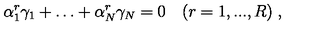

In [26]:
image = Image.open(root_dir + test_df['file_name'][0]).convert("RGB")
image

In [27]:
encoding = dataset[0]
labels = encoding['labels']
labels[labels == -100] = tokenizer.token_to_id("[PAD]")
label_str = tokenizer.decode(labels.tolist(), skip_special_tokens=True)
print(label_str)

\ alpha _ { 1 } ^ { r } \ gamma _ { 1 } + \ dots + \ alpha _ { N } ^ { r } \ gamma _ { N } = 0 \ quad ( r = 1 , . . . , R ) \; ,


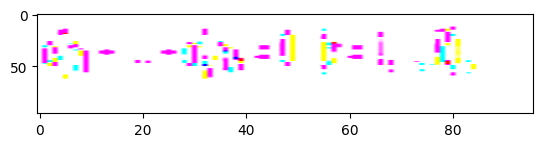

In [28]:
image = latent_im[0].numpy()
plt.imshow(image.transpose([1,2,0]), aspect=1/5)

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, valid_ds = torch.utils.data.random_split(dataset, [train_size, test_size]) # 80-20 split

In [ ]:
latent_train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
latent_test_dataloader = DataLoader(valid_ds, batch_size=batch_size)

# Training the model

In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.token_to_id("[CLS]")
model.config.pad_token_id = tokenizer.token_to_id("[PAD]")
# make sure vocab size is set correctly
model.config.vocab_size = vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.token_to_id("[SEP]")
model.config.max_length = max_length #64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

model.tokenizer = tokenizer

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

for epoch in range(num_epoch):
   model.train()
   train_loss = 0.0
   for i, batch in (latent_train_dataloader):
      for k,v in batch.items():
        batch[k] = v.to(device)

      outputs = model(batch["pixel_values"])
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()
      if i % report_step == 0: print(f"Loss: {loss.item()}")

   print(f"Loss after epoch {epoch}:", train_loss/len(latent_train_dataloader))


Loss: 1.084360957145691
Loss: 0.6191284656524658
Loss: 0.44885754585266113
Loss after epoch 0: 1.220638786192386

Loss: 0.7492675185203552
Loss: 0.2720032334327698
Loss: 0.18899774551391602
Loss after epoch 1: 0.2779880609216817

Loss: 0.18001404404640198
Loss: 0.08790895342826843
Loss: 0.07462706416845322
Loss after epoch 2: 0.16063970290371754


In [ ]:
i = 0
for batch in (latent_test_dataloader):
    for k,v in batch.items():
        batch[k] = v.to(device)
    outputs = model.generate(batch["pixel_values"].to(device))
    px = batch["pixel_values"][i].cpu().numpy()
    labels = batch["labels"][i]
    pred = outputs[i]
    break

Predicted Label: \alpha_{1}^{r}\gamma_{1}+\dots+\alpha_{N}^{r}\gamma_{N}=0\quad(r=1,...,R)\;,
True Label: \alpha _ { 1 } ^ { r } \gamma _ { 1 } + \dots + \alpha _ { N } ^ { r } \gamma _ { N } = 0 \quad ( r = 1 , . . . , R ) \; ,
Original image: 


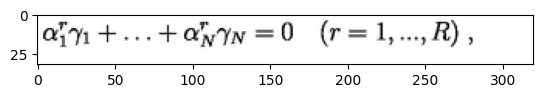

In [39]:
label_true = tokenizer.decode(labels.tolist()).replace(" ", "")
label_pred = tokenizer.decode(pred.tolist()).replace(" ", "")

print( 'Pred. label: ' + label_pred )
print( 'True label: ' + label_true )
print("Original image: ")
plt.imshow(px.transpose([1,2,0]), aspect=1/5)

In [40]:
pred_latex = Latex(f'${label_pred}$')
display(pred_latex)

<IPython.core.display.Latex object>

In [ ]:
def get_pred_and_label_str(pred, label):
    pred_str = tokenizer.decode_batch(pred.tolist(), skip_special_tokens=True)
    label[label == -100] = tokenizer.token_to_id("[PAD]")
    label_str = tokenizer.decode_batch(label.tolist(), skip_special_tokens=True)
    return (pred_str, label_str)

In [ ]:
import nltk
candidate_corpus = []
references_corpus = []
valid_bleu = 0.0

model.eval()

with torch.no_grad():
    for i, batch in (latent_test_dataloader):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))
        # compute metrics
        pred, label = get_pred_and_label_str(outputs, batch["labels"])

        for s in pred: s = s.split(" ")
        for s in label: s = s.split(" ")
        candidate_corpus.extend(pred)
        references_corpus.extend(label)

valid_bleu =  nltk.translate.bleu_score.corpus_bleu(
        references_corpus, candidate_corpus,
        weights=(0.25, 0.25, 0.25, 0.25)
)
print("Validation BLEU:", valid_bleu / len(latent_test_dataloader))

Validation BLEU: 0.6429031480226426


In [ ]:
# 0.67539906839 BLEU score for vanilla TrOCR